# CS441: Applied ML - HW 4

## Part I: Clustering and Fast Retrieval

Include all the code for Part 1 in this section

In [ ]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 1s (523 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 122352 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd64.

In [ ]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

11490434/11490434 [==============================] - 1s 0us/step


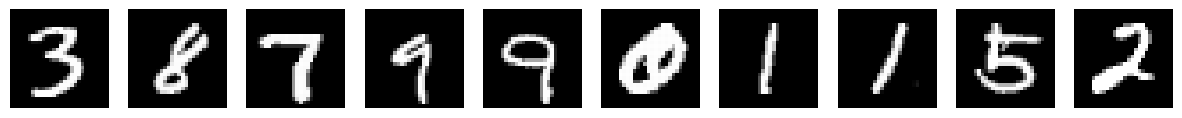

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [ ]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

In [ ]:
## Helper functions

# Returns the purity of the clustering according to labels, 
# and the label counts of each cluster
# def get_purity(labels, cluster_idx):
#   nclasses = int(max(labels)+1)
#   nidx = int(max(cluster_idx)+1)
#   counts = np.zeros((nidx, nclasses), np.int32)
#   for i in range(len(labels)):
#     c = labels[i]
#     print(c)
#     idx = cluster_idx[i]
#     print()
#     counts[idx, c]+=1
#   purity = np.sum(np.max(counts, axis=1))/len(cluster_idx)
#   return purity, counts

def get_purity(labels, cluster_idx):
  nclasses = int(np.amax(labels)+1)
  nidx = int(np.amax(cluster_idx)+1)
  counts = np.zeros((nidx, nclasses), np.int32)
  for i in range(len(labels)):
    c = labels[i]
    idx = cluster_idx[i]
    counts[idx, c]+=1
  purity = np.sum(np.amax(counts, axis=1))/len(cluster_idx)
  return purity, counts
# Returns an index list that can be used to re-order the counts according to 
# which label is most common 
def get_cluster_order(counts):
  idx = np.argmax(counts, axis=1)
  idx = np.argsort(idx)
  return idx 

###*Problem* 1.1 Clustering

K = 10.0000
number of purity = 0.6191
number of distance = 39.5651


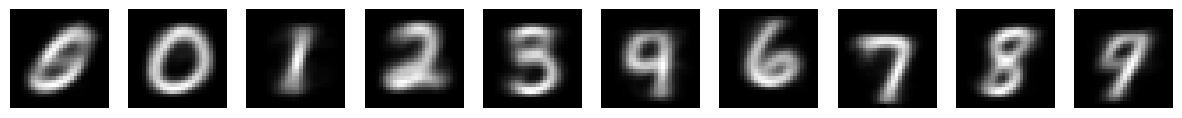

K = 20.0000
number of purity = 0.7209
number of distance = 35.5193


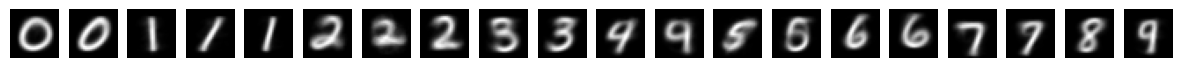

K = 30.0000
number of purity = 0.7552
number of distance = 33.3720


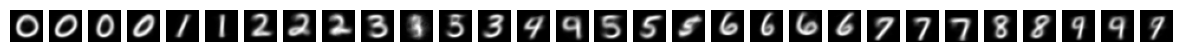

K = 40.0000
number of purity = 0.7834
number of distance = 32.0445


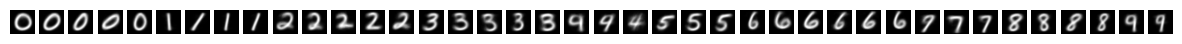

K = 50.0000
number of purity = 0.8009
number of distance = 30.9322


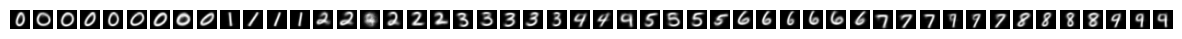

K = 60.0000
number of purity = 0.8257
number of distance = 30.1527


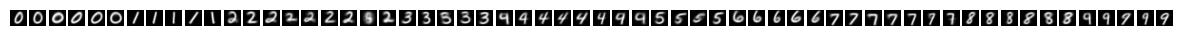

K = 70.0000
number of purity = 0.8501
number of distance = 29.6361


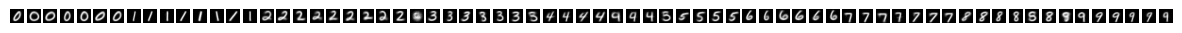

K = 80.0000
number of purity = 0.8662
number of distance = 29.0251


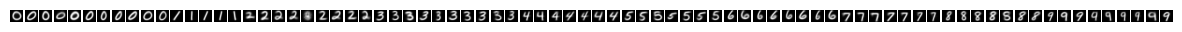

K = 90.0000
number of purity = 0.8678
number of distance = 28.7041


K = 100.0000
number of purity = 0.8657
number of distance = 28.2736


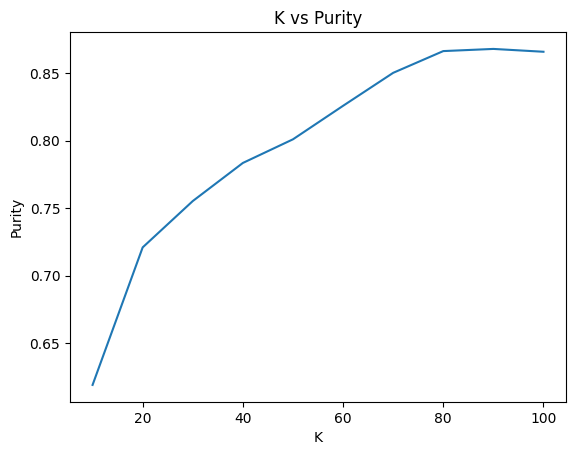

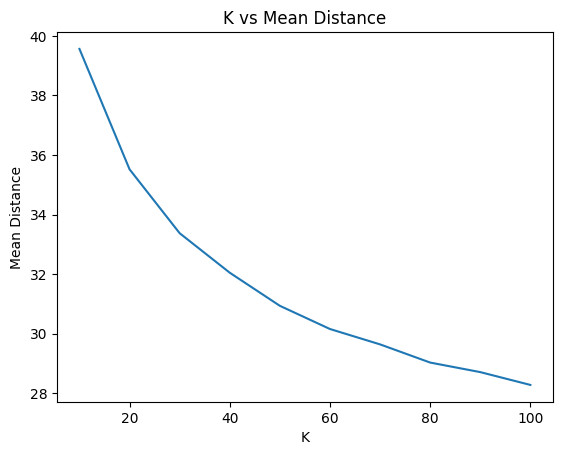

In [ ]:
# set dimensions
dim = x_train.shape[1]

# Set the number of clusters
clusters =  [10,20,30,40,50,60,70,80,90,100]

purity_k = []
mean_k = []

for K in clusters:
  # Initialize the k-means clustering object
  kmeans = faiss.Kmeans(dim, K, niter=100, verbose = True)

  # Train the k-means model
  kmeans.train(x_train)

  # Assign each data point to a cluster
  _,cluster_id = kmeans.index.search(x_test, 1)
  cluster_id = cluster_id.astype(int)
  # print(cluster_id.shape)
  # print(y_test.shape)
  distance,_ = kmeans.index.search(x_test, 1)
  distance = np.mean(distance)
  # Record and print Purity
  purity, counts = get_purity(y_test, cluster_id)
  purity_k.append(purity)
  idx = get_cluster_order(counts)
  # idx = np.argsort(counts)[::-1]
  # idx = np.where(idx < K)[0]
  print(f"K = {K:.4f}")
  print(f"number of purity = {purity:.4f}")
  print(f"number of distance = {distance:.4f}")
  display_mnist(kmeans.centroids[idx,:], 1, K)
  mean_k.append(distance)
#Plot K vs Purity and K vs Mean_Distances
plt.plot(clusters, purity_k, label='Purity')
plt.xlabel('K')
plt.ylabel('Purity')
plt.title('K vs Purity')
plt.show()

plt.plot(clusters, mean_k, label='Mean Distance')
plt.xlabel('K')
plt.ylabel('Mean Distance')
plt.title('K vs Mean Distance')
plt.show()

### Problem 1.2 Fast Retrieval

In [ ]:
## Brute Force (IndexFlatL2)

# set dimensions
dim = x_train.shape[1]

start_time = time.time()

# Initialize the index for Brute Force
index_flatl2 = faiss.IndexFlatL2(dim)
# Add Data & Print time to add
index_flatl2.add(x_train)
print(f"Time to add data to index: {time.time() - start_time:.4f}s")

# Perform Search and Compute Time required
start_search_time = time.time()
_, brute_force_idx = index_flatl2.search(x_test, 1)
search_time = time.time() - start_search_time
print(f"Time for search: {search_time:.4f} seconds\n")

# Compute Test Error
test_error = 1 - np.mean(y_test == y_train[brute_force_idx.reshape(-1)])

print(f"Brute Force Test Error: {test_error:.4f}")

Time to add data to index: 0.2531s
Time for search: 13.8249 seconds

Brute Force Test Error: 0.0331


In [ ]:
## LSH

# set dimensions
dim = x_train.shape[1]
nbits = 2*dim
print(f"number of nbits: {nbits:.4f}")
start_time = time.time()
# Initialize the index for LSH
index_lsh = faiss.IndexLSH(dim, nbits)
# Add Data & Print time to add
index_lsh.add(x_train)
print(f"Time to add data to index: {time.time() - start_time:.4f}s")
# Perform Search and Compute Time required
_, lsh_idx = index_lsh.search(x_test, 1)
search_time_lsh = time.time() - start_time
print(f"Time for search: {search_time_lsh:.4f} seconds\n")
test_error = 1 - np.mean(y_test == y_train[lsh_idx.reshape(-1)])
print(f"LSH Test Error: {test_error:.4f}")
print("------------------------------------")




## different nbits
nbits = int(dim / 2)
start_time = time.time()
print(f"number of nbits: {nbits:.4f}")
# Initialize the index for LSH
index_lsh = faiss.IndexLSH(dim, nbits)
# Add Data & Print time to add
index_lsh.add(x_train)
print(f"Time to add data to index: {time.time() - start_time:.4f}s")
# Perform Search and Compute Time required
_, lsh_idx = index_lsh.search(x_test, 1)
search_time_lsh1 = time.time() - start_time
print(f"Time for search: {search_time_lsh1:.4f} seconds\n")
test_error_2 = 1 - np.mean(y_test == y_train[lsh_idx.reshape(-1)])
print(f"LSH Test Error: {test_error_2:.4f}")
print("------------------------------------")

## different nbits
nbits = int(dim*1.5)
start_time = time.time()
print(f"number of nbits: {nbits:.4f}")
# Initialize the index for LSH
index_lsh = faiss.IndexLSH(dim, nbits)
# Add Data & Print time to add
index_lsh.add(x_train)
print(f"Time to add data to index: {time.time() - start_time:.4f}s")
# Perform Search and Compute Time required
_, lsh_idx = index_lsh.search(x_test, 1)
search_time_lsh2 = time.time() - start_time
print(f"Time for search: {search_time_lsh2:.4f} seconds\n")
test_error_3 = 1 - np.mean(y_test == y_train[lsh_idx.reshape(-1)])
print(f"LSH Test Error: {test_error_3:.4f}")
print("------------------------------------")




number of nbits: 1568.0000
Time to add data to index: 2.7257s
Time for search: 18.2927 seconds

LSH Test Error: 0.0318
------------------------------------
number of nbits: 392.0000
Time to add data to index: 0.8765s
Time for search: 5.9696 seconds

LSH Test Error: 0.0425
------------------------------------
number of nbits: 1176.0000
Time to add data to index: 1.7124s
Time for search: 13.8851 seconds

LSH Test Error: 0.0326
------------------------------------


## Part 2: Estimating PDFs

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/MyDrive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

Mounted at /content/drive


In [ ]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

#### Method 1 (Per-dimension discrete pdf)

In [ ]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  # TO DO: 
  # (1) loop through values
  # (2) increment element of p corresponding to each value
  # (3) divide by sum of p  
  for i in range(len(x)):
    p[int(x[i])] += 1
  p = p/np.sum(p)  
  return p

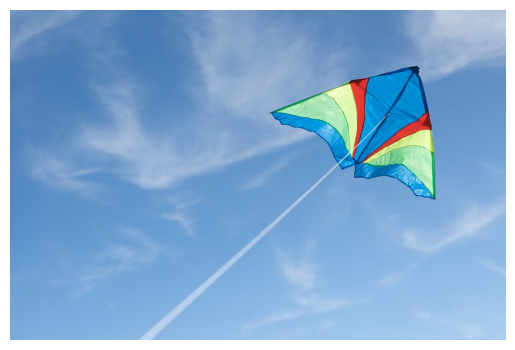

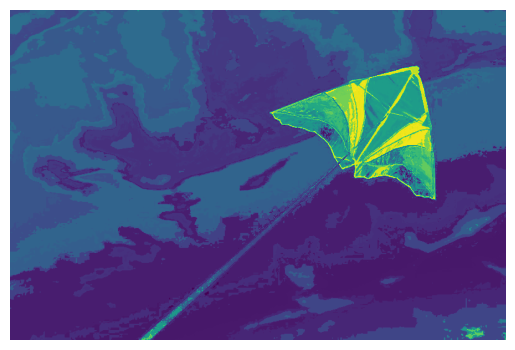

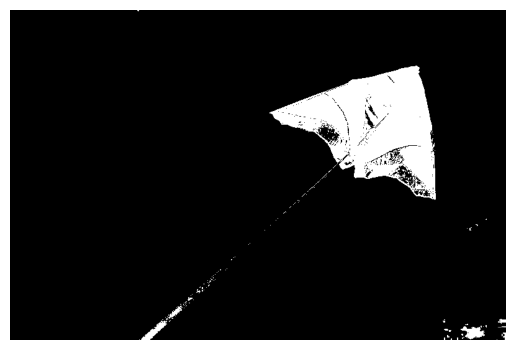

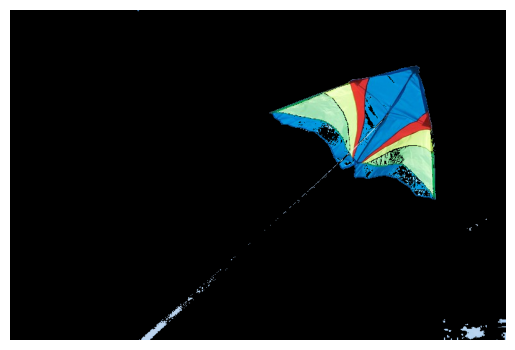

In [ ]:
# set number of bins K
K = 16
# reshape pixels to (h*w, 3)
h, w, c = im.shape
full_pixel = im.reshape(h*w, c)

h1,w1,c1 = crop.shape
crop_pixel = crop.reshape(h1*w1, c1)
# convert continuous values to discrete values ranging from 0 to K-1 
full_discrete = np.minimum((full_pixel*K).astype(int), K-1)
crop_discrete = np.minimum((crop_pixel*K).astype(int), K-1)
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1

# get pdf for each dimension using estimate_discrete_pdf
pdf_full = np.zeros((K,3))
pdf_crop = np.zeros((K,3))
for i in range(c):
  pdf_full[:, i] = estimate_discrete_pdf(full_discrete[:, i], K)
  pdf_crop[:, i] = estimate_discrete_pdf(crop_discrete[:, i], K)

# estimate score for each pixel in full image according to log pdfs
score = np.zeros((h*w, 3), dtype = float)
for i in range(3):
  score[:,i] = np.log(pdf_crop[full_discrete[:,i],i]) - np.log(pdf_full[full_discrete[:,i],i])

score_map = np.sum(score, axis = -1)
score_map = score_map.reshape(h, w)
# display
# plt.imshow(score_map, cmap=None)
# plt.axis('off')
# plt.show()

threshold = 0
display_score_maps(im, score_map, threshold)

#### Method 2 (K-means)

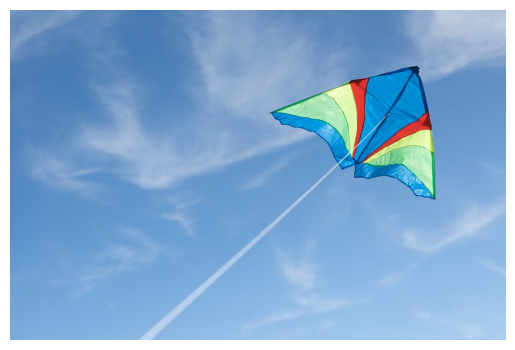

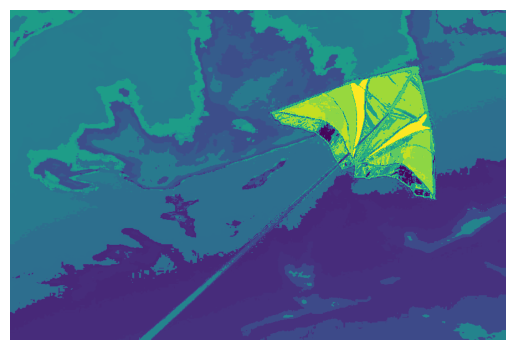

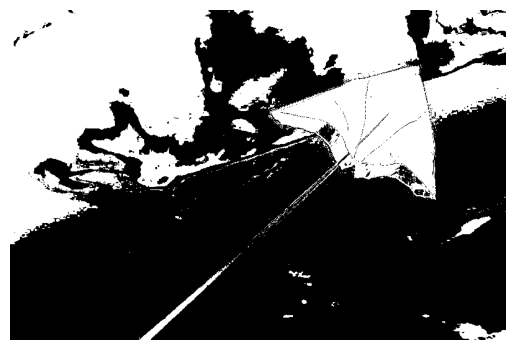

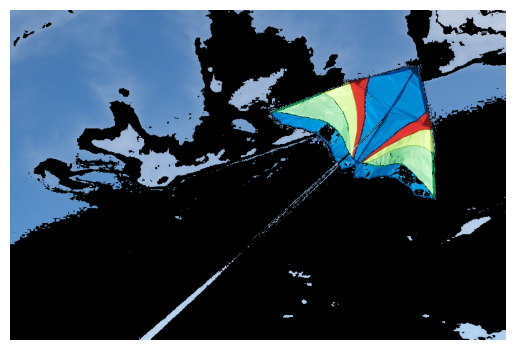

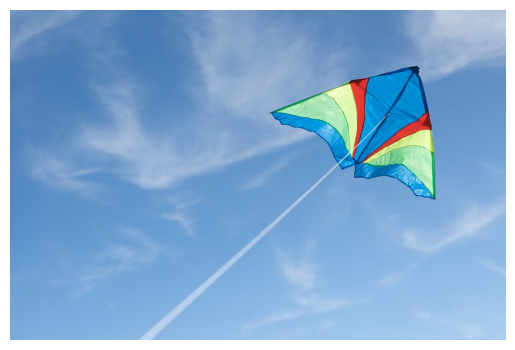

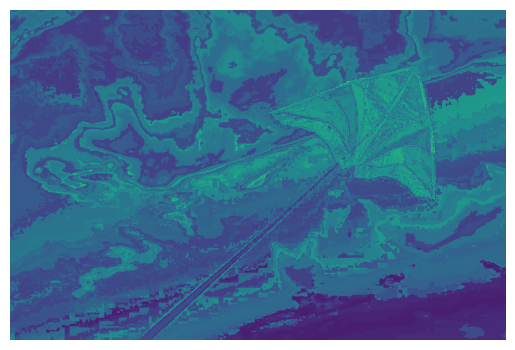

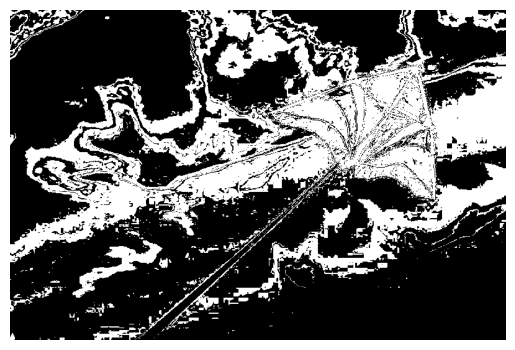

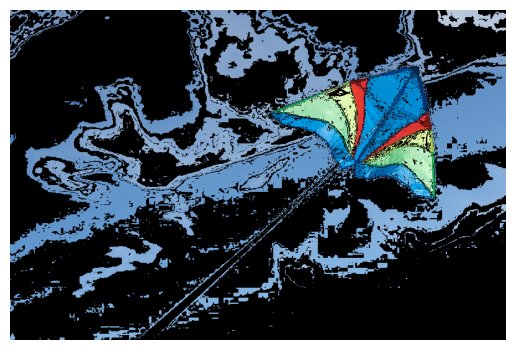

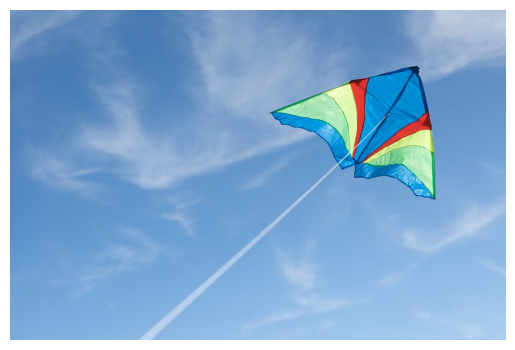

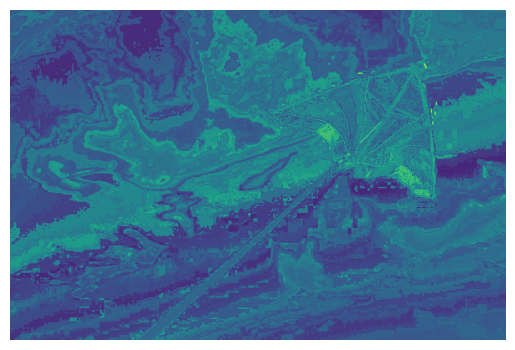

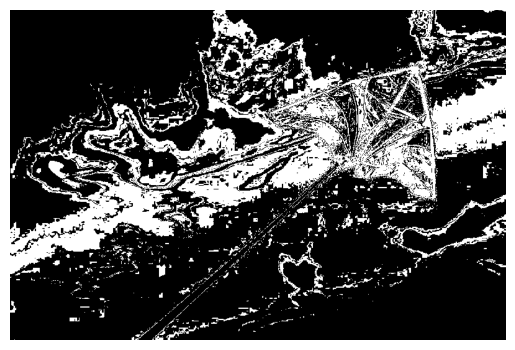

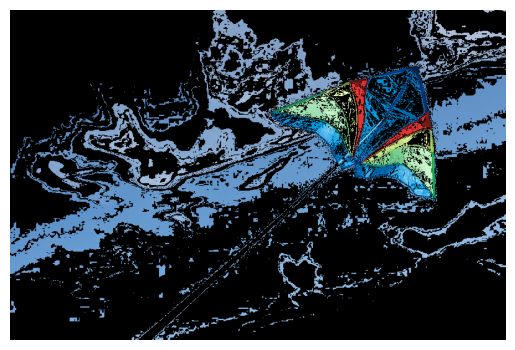

In [ ]:
import faiss

# set K
K_value = [16, 128, 256]

for K in K_value:

  # reshape pixels to (h*w, 3)
  h, w = im.shape[:2]
  pixels = np.reshape(im, (h*w, 3))

  h1, w1 = crop.shape[:2]
  pixels_crop = np.reshape(crop, (h1*w1, 3))

  # discretize all three color channels together using KMeans
  kmeans = faiss.Kmeans(3, K, niter = 20)
  kmeans.train(pixels.astype('float32'))

  pixel_assign, I_im = kmeans.index.search(pixels.astype('float32'), 1)


  kmeans_2 = faiss.Kmeans(3, K, niter = 20)
  kmeans_2.train(pixels_crop.astype('float32'))

  crop_assign, I_crop = kmeans_2.index.search(pixels_crop.astype('float32'), 1)

  D1, T1 = kmeans_2.index.search(pixels, 1)


  # get pdf over discrete values
  counts = np.bincount(I_im.flatten(), minlength=K) + 1
  pdf = counts / np.sum(counts)

  counts_2 = np.bincount(I_crop.flatten(), minlength=K) + 1
  pdf_2 = counts_2 / np.sum(counts_2)

  # estimate score for each pixel in full and crop image according to log pdfs


  score_map2 = np.zeros([h*w, 1])
  for i in range(len(I_im)):
    a = int(T1[i])
    b = int(I_im[i])
    score_map2[i] = np.log(pdf_2[a] / pdf[b])

  # display
  # plt.imshow(score_map_1, cmap = None)
  # plt.axis('off')
  # plt.show()
  threshold = 0
  display_score_maps(im, score_map2, threshold)

  # plt.imshow(score_map_crop, cmap = None)
  # plt.axis('off')
  # plt.show()





#### Method 3 (GMM)

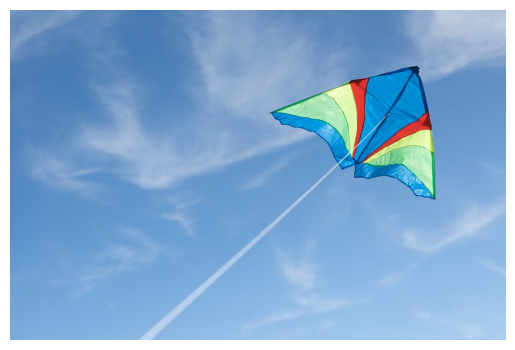

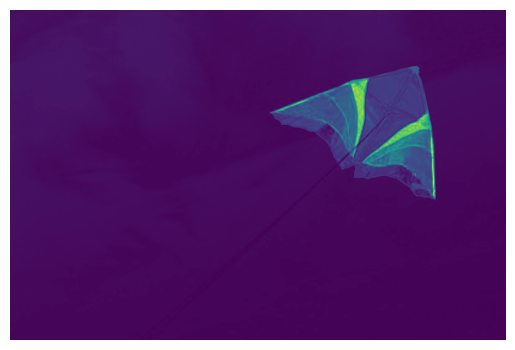

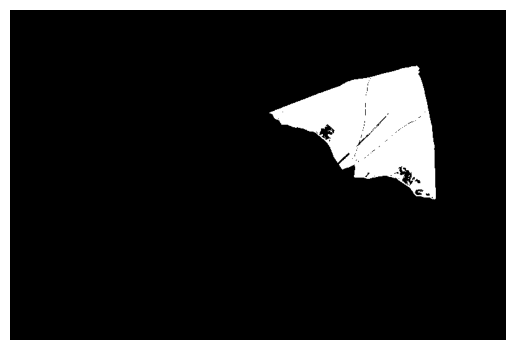

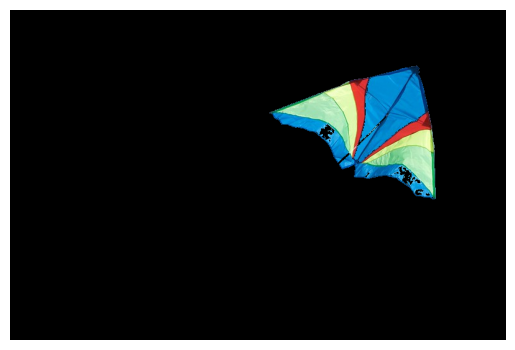

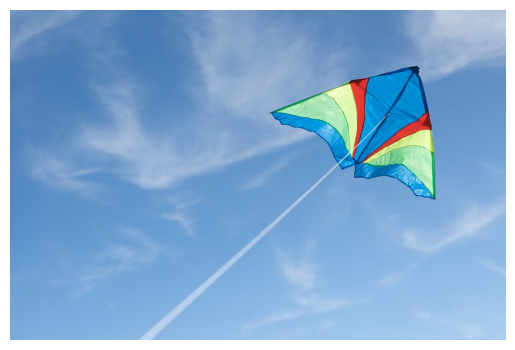

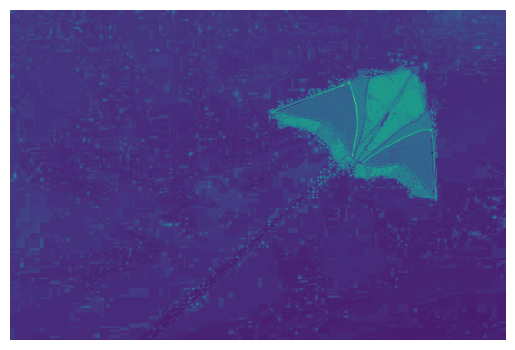

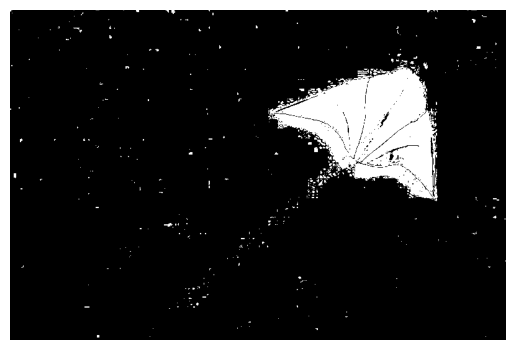

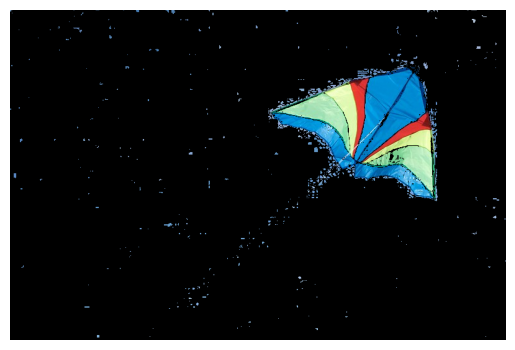

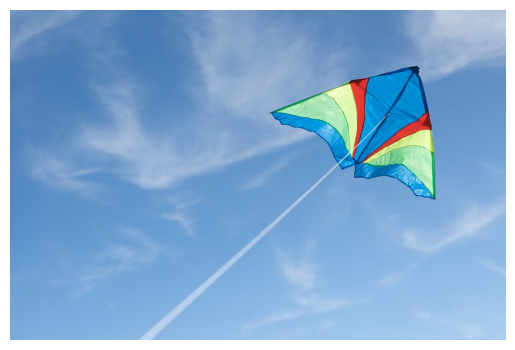

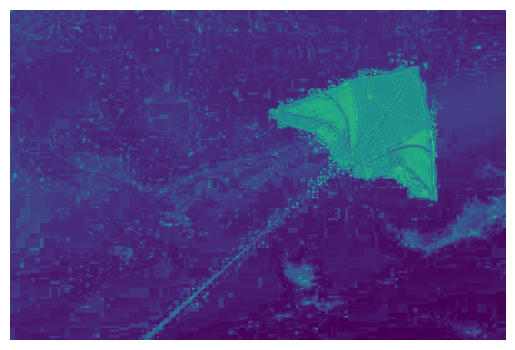

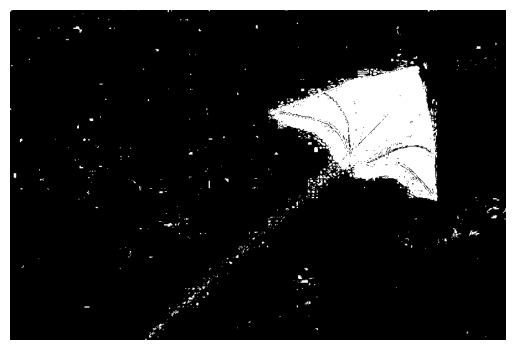

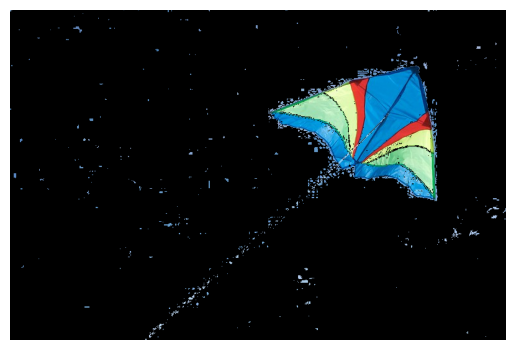

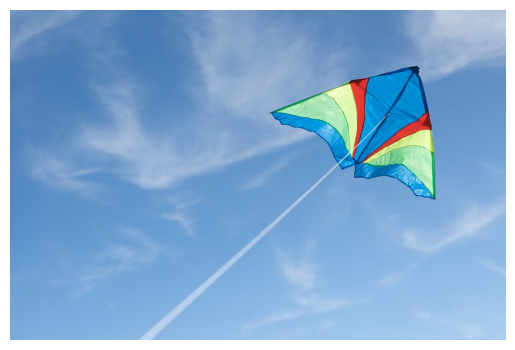

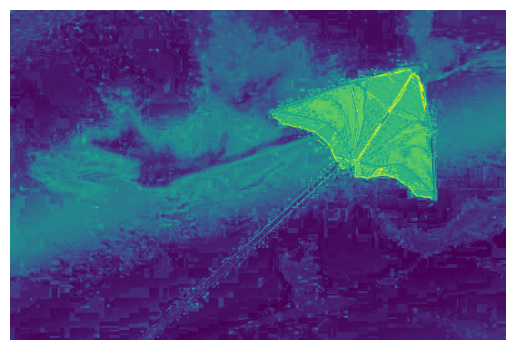

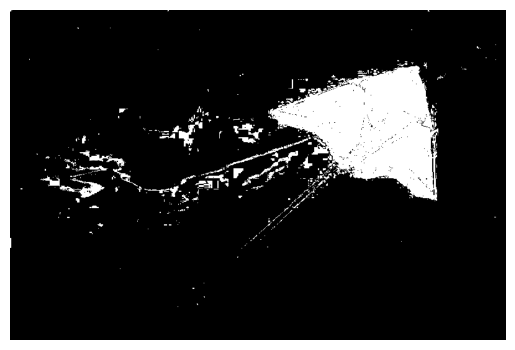

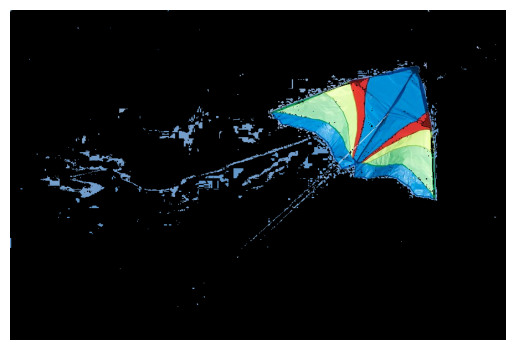

In [ ]:
from sklearn.mixture import GaussianMixture

n_components_array = [1,3,5,10]
# reshape pixels to (h*w, 3)
for n_components in n_components_array:

  h, w, c = im.shape
  im_flat = im.reshape(h*w, c)

  h1, w1, c1 = crop.shape
  crop_flat = crop.reshape(h1*w1, c1)
  # get joint pdf using GMMs (choose number of components and other parameters)
  gmm = GaussianMixture(n_components=n_components, covariance_type='full')
  gmm.fit(im_flat)

  gmm1 = GaussianMixture(n_components=n_components, covariance_type='full')
  gmm1.fit(crop_flat)

  joint_pdf = np.exp(gmm.score_samples(im_flat))

  joint_pdf_crop = np.exp(gmm1.score_samples(im_flat))

  score_map_gmm =np.log(joint_pdf_crop) - np.log(joint_pdf)
  score_map_gmm = score_map_gmm.reshape(h, w)

  # display
  threshold = 0
  display_score_maps(im, score_map_gmm, threshold)





## Part 3: PCA and Data Compression

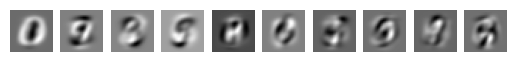

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import faiss

(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Compute the principal components using x_train
x_train_new = x_train.reshape(x_train.shape[0], -1)
pca = PCA(n_components = 10)
pca.fit(x_train_new)

# Display First 10 Components
figure, axes = plt.subplots(1, 10)

for i, ax in enumerate(axes.ravel()):
  ax.imshow(pca.components_[i].reshape(28,28), cmap = "gray")
  ax.axis("off")
plt.show()

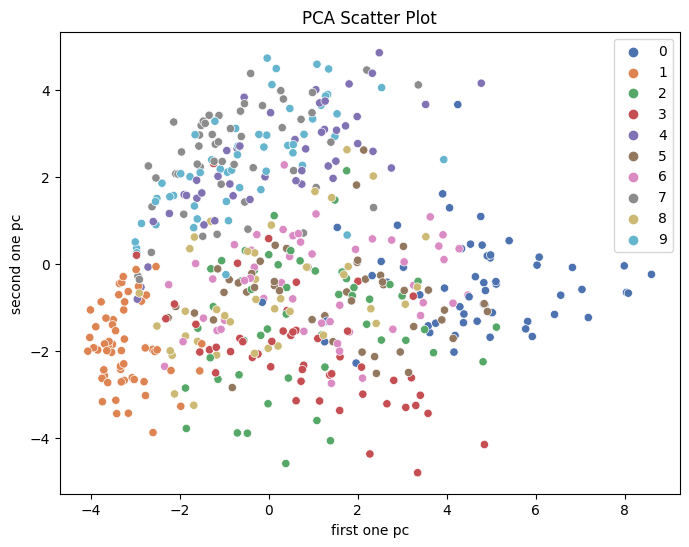

In [ ]:
# Scatter plot of first two PCA dimensions
import seaborn as sns  #sns.scatterplot(x, y, hue=labels)

pca = PCA(n_components = 2)
pca_train = pca.fit_transform(x_train_new)
samples = x_train_new[train_indices['s']]
pca_s = pca.transform(samples)

plt.figure(figsize = (8,6))
sns.scatterplot(x = pca_s[:, 0], y = pca_s[:, 1], hue=y_train[train_indices['s']], 
                palette = 'deep', legend='full')
plt.xlabel("first one pc")
plt.ylabel("second one pc")
plt.title('PCA Scatter Plot')
plt.show()


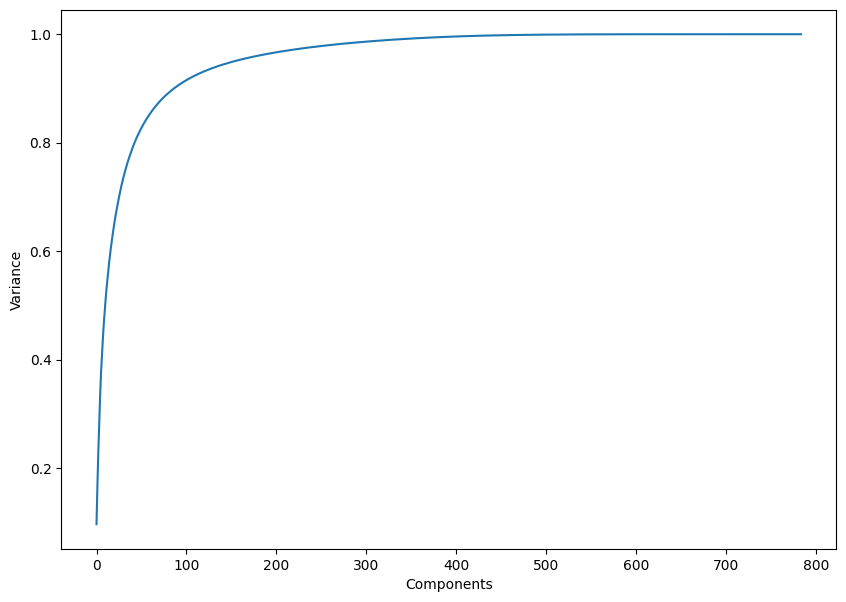

In [ ]:
# Plot cumulative explained variance
pca = PCA()
pca.fit(x_train_new)

cev = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
plt.plot(cev)
plt.xlabel("Components")
plt.ylabel("Variance")
plt.show()


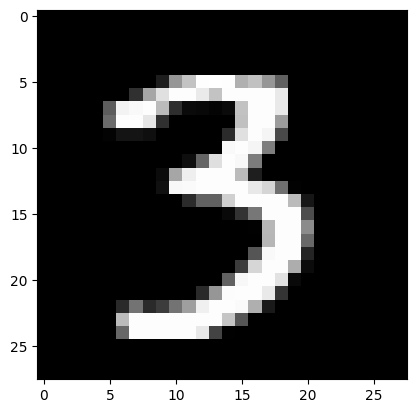

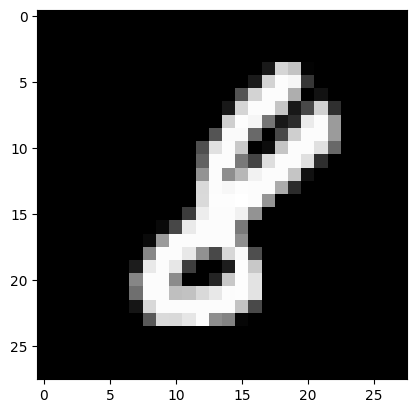

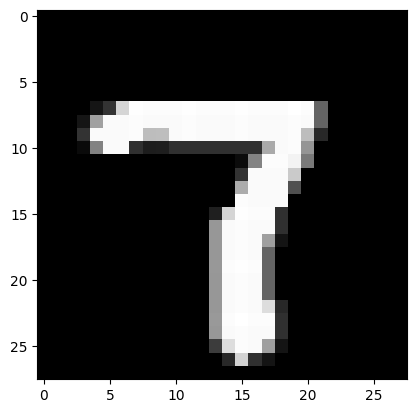

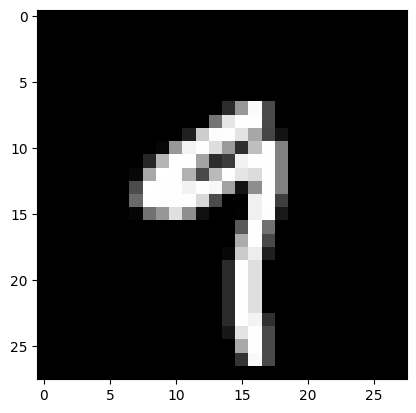

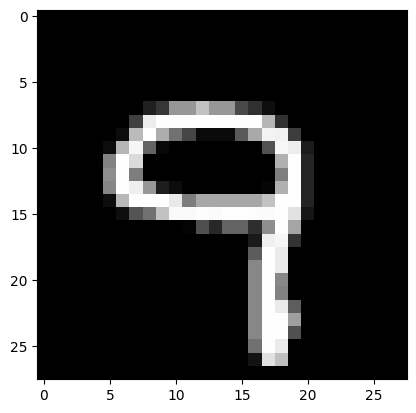

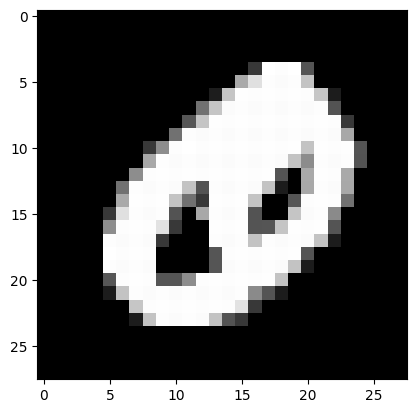

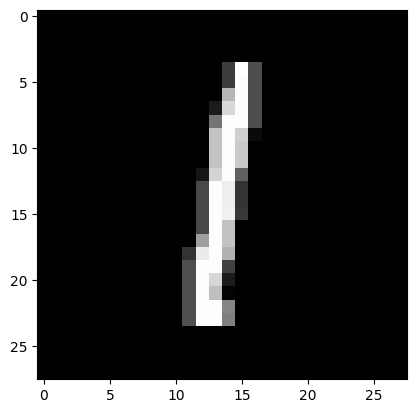

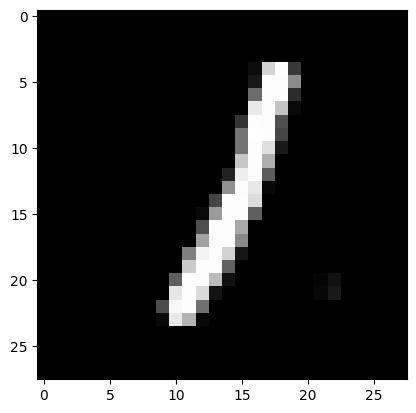

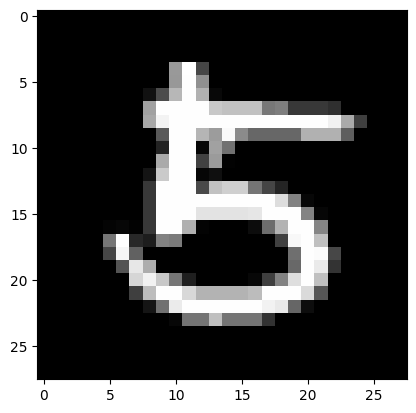

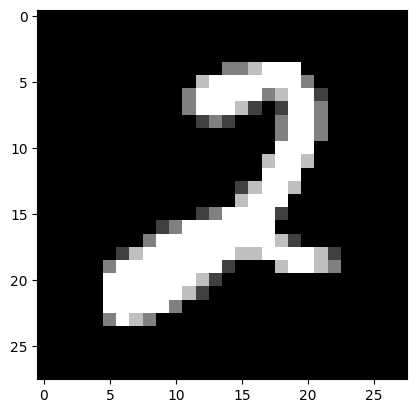

add time: 0.0216 seconds
search time: 1.9022 seconds
test error:  0.029100000000000015


In [ ]:
from sklearn.metrics import accuracy_score
# Select number of dimensions that explains 90% of variance, according to your plot above
x_trainflat = x_train.reshape(x_train.shape[0], -1)
x_testflat = x_test.reshape(x_test.shape[0], -1)
pca = PCA()
pca.fit(x_trainflat)
M = int(np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0] + 1)

# Display the first 10 samples before and after PCA compression
pca = PCA(n_components = M)
x_trainpca = pca.fit_transform(x_trainflat)
x_testpca = pca.transform(x_testflat)

x_train_reshaped = x_train.reshape(x_train.shape[0], 28, 28)
x_test_reshaped = x_test.reshape(x_test.shape[0], 28, 28)
# Initialize the index for Brute Force
for i in range(10):
  plt.imshow(x_train_reshaped[i], cmap = 'gray')
  plt.show()

index = faiss.IndexFlatL2(M)

# Add Data & Print time to add
start_time = time.time()
index.add(x_trainpca.astype(np.float32))
end_time = time.time()
print(f"add time: {end_time - start_time:.4f} seconds")

# Perform Search and Compute Time required
start_time = time.time()
D, I = index.search(x_testpca.astype(np.float32), 1)
end_time = time.time()
print(f"search time: {end_time - start_time:.4f} seconds")

# Compute Test Error
predicted_labels = y_train[I].flatten()
test_error = 1 - accuracy_score(y_test, predicted_labels)
print("test error: ", test_error)


## Part 4: Stretch Goals
Include all your code used for part 4 in this section. You can copy-paste code from parts 1, 2 or 3 if it is re-usable.

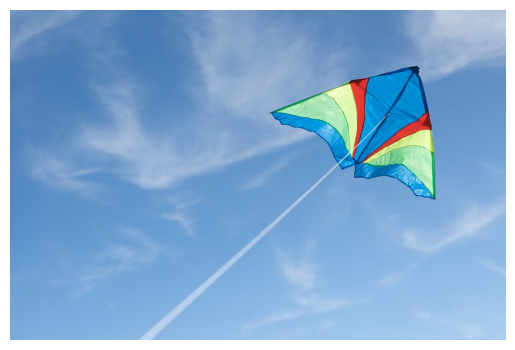

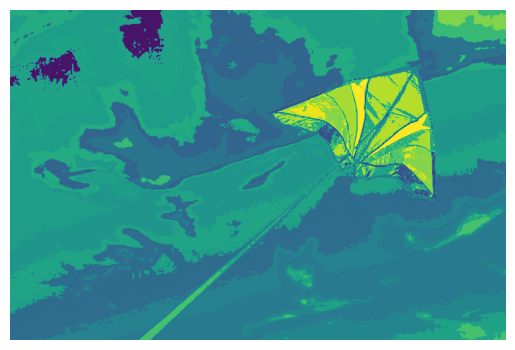

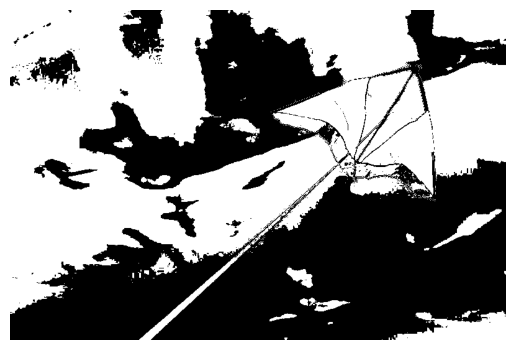

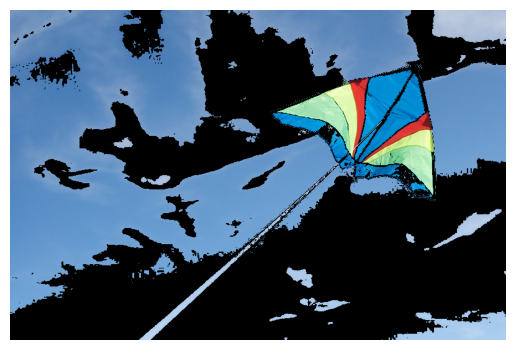

In [ ]:
K = 20
im_pixels = im.reshape(h*w, 3).astype(np.float32)
crop_pixels = crop.reshape(h1*w1, 3).astype(np.float32)
pca = PCA(n_components=3)
pca.fit(im_pixels)
full_pixels_pca = pca.transform(im_pixels)
crop_pixels_pca = pca.transform(crop_pixels)
kmeans1 = faiss.Kmeans(3, K, niter=20, verbose=True, gpu=True)
kmeans2 = faiss.Kmeans(3, K, niter=20, verbose=True, gpu=True)
kmeans1.train(full_pixels_pca)
kmeans2.train(crop_pixels_pca)
full_assignments, I_im = kmeans1.index.search(full_pixels_pca, 1)
crop_assignments, I_crop = kmeans2.index.search(crop_pixels_pca, 1)
D1, I1 = kmeans2.index.search(full_pixels_pca, 1)


count_full = np.bincount(I_im.flatten(), minlength=K) + 1
fullpdf = count_full / np.sum(count_full)

count_crop = np.bincount(I_crop.flatten(), minlength=K) + 1
croppdf = count_crop / np.sum(count_crop)

score_map = np.zeros([h*w, 1])
for i in range(len(I_im)):
    a = int(I1[i])
    b = int(I_im[i])
    score_map[i] = np.log(croppdf[a] / fullpdf[b])
threshold = 0
display_score_maps(im, score_map, threshold)
